In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None) # display all columns
pd.set_option('display.max_rows', None) # display all columns

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [2]:
data = pd.read_csv('data/Kobe.csv')

In [3]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [4]:
data.dtypes

action_type            object
combined_shot_type     object
game_event_id           int64
game_id                 int64
lat                   float64
loc_x                   int64
loc_y                   int64
lon                   float64
minutes_remaining       int64
period                  int64
playoffs                int64
season                 object
seconds_remaining       int64
shot_distance           int64
shot_made_flag        float64
shot_type              object
shot_zone_area         object
shot_zone_basic        object
shot_zone_range        object
team_id                 int64
team_name              object
game_date              object
matchup                object
opponent               object
shot_id                 int64
dtype: object

In [5]:
target = 'shot_made_flag'

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge на тех же признаках - построить сравнительную таблицу коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. Посчитать RSS

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной


1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels

In [6]:
#Создадим явный индекс, присвоим некоторым колонкам категорийный тип

data.set_index('shot_id', inplace=True)
data["action_type"] = data["action_type"].astype('object')
data["combined_shot_type"] = data["combined_shot_type"].astype('category')
data["game_event_id"] = data["game_event_id"].astype('category')
data["game_id"] = data["game_id"].astype('category')
data["period"] = data["period"].astype('object')
data["playoffs"] = data["playoffs"].astype('category')
data["season"] = data["season"].astype('category')
data["shot_made_flag"] = data["shot_made_flag"].astype('category')
data["shot_type"] = data["shot_type"].astype('category')
data["team_id"] = data["team_id"].astype('category')

In [7]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent
shot_id,,,,,,,,,,,,,,,,,,,,,,,,
1,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
2,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
3,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
4,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
5,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR


In [8]:
data.dtypes

action_type             object
combined_shot_type    category
game_event_id         category
game_id               category
lat                    float64
loc_x                    int64
loc_y                    int64
lon                    float64
minutes_remaining        int64
period                  object
playoffs              category
season                category
seconds_remaining        int64
shot_distance            int64
shot_made_flag        category
shot_type             category
shot_zone_area          object
shot_zone_basic         object
shot_zone_range         object
team_id               category
team_name               object
game_date               object
matchup                 object
opponent                object
dtype: object

In [9]:

data.shape

(30697, 24)

In [10]:
data.describe(include=['number'])

,lat,loc_x,loc_y,lon,minutes_remaining,seconds_remaining,shot_distance
count,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000
mean,33.953192,7.110499,91.107535,-118.262690,4.885624,28.365085,13.437437
std,0.087791,110.124578,87.791361,0.110125,3.449897,17.478949,9.374189
min,33.253300,-250.000000,-44.000000,-118.519800,0.000000,0.000000,0.000000
25%,33.884300,-68.000000,4.000000,-118.337800,2.000000,13.000000,5.000000
50%,33.970300,0.000000,74.000000,-118.269800,5.000000,28.000000,15.000000
75%,34.040300,95.000000,160.000000,-118.174800,8.000000,43.000000,21.000000
max,34.088300,248.000000,791.000000,-118.021800,11.000000,59.000000,79.000000


In [11]:
data.describe()

,lat,loc_x,loc_y,lon,minutes_remaining,seconds_remaining,shot_distance
count,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000
mean,33.953192,7.110499,91.107535,-118.262690,4.885624,28.365085,13.437437
std,0.087791,110.124578,87.791361,0.110125,3.449897,17.478949,9.374189
min,33.253300,-250.000000,-44.000000,-118.519800,0.000000,0.000000,0.000000
25%,33.884300,-68.000000,4.000000,-118.337800,2.000000,13.000000,5.000000
50%,33.970300,0.000000,74.000000,-118.269800,5.000000,28.000000,15.000000
75%,34.040300,95.000000,160.000000,-118.174800,8.000000,43.000000,21.000000
max,34.088300,248.000000,791.000000,-118.021800,11.000000,59.000000,79.000000


In [12]:
data.describe(include=['object', 'category'])

,action_type,combined_shot_type,game_event_id,game_id,period,playoffs,season,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent
count,30697,30697,30697,30697,30697,30697,30697,25697.0,30697,30697,30697,30697,30697,30697,30697,30697,30697
unique,57,6,620,1559,7,2,20,2.0,2,6,7,5,1,1,1559,74,33
top,Jump Shot,Jump Shot,2,21501228,3,0,2005-06,0.0,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,1610612747,Los Angeles Lakers,2016-04-13,LAL @ SAS,SAS
freq,18880,23485,132,50,8296,26198,2318,14232.0,24271,13455,12625,9398,30697,30697,50,1020,1978


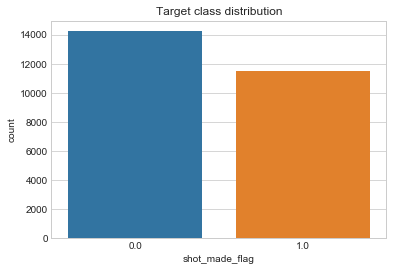

In [13]:
#Посмотрим на распредление целевой переменной

import seaborn as sns
ax = plt.axes()
sns.countplot(x='shot_made_flag', data=data, ax=ax);
ax.set_title('Target class distribution')
plt.show()

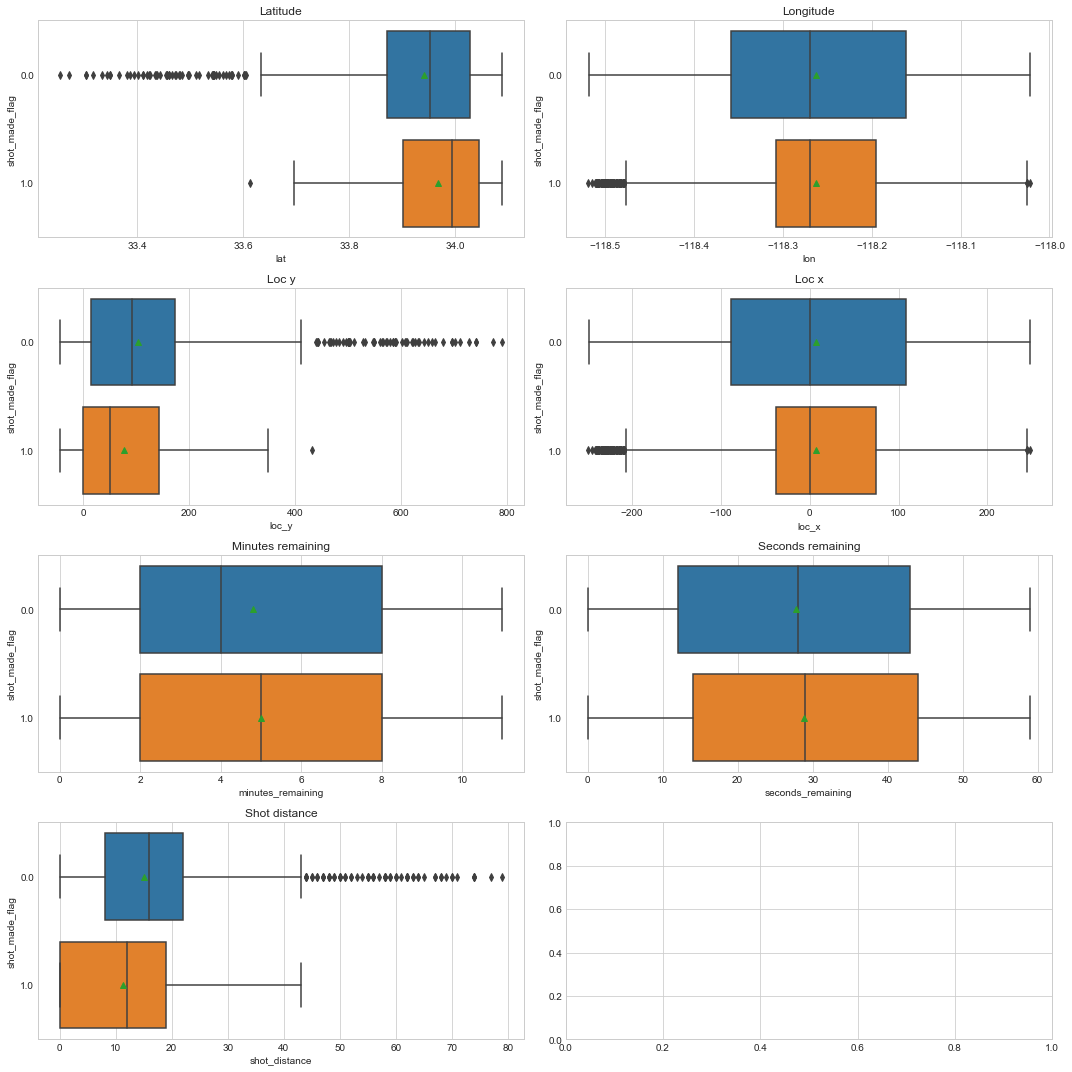

In [14]:
f, axarr = plt.subplots(4, 2, figsize=(15, 15))

sns.boxplot(x='lat', y='shot_made_flag', data=data, showmeans=True, ax=axarr[0,0])
sns.boxplot(x='lon', y='shot_made_flag', data=data, showmeans=True, ax=axarr[0, 1])
sns.boxplot(x='loc_y', y='shot_made_flag', data=data, showmeans=True, ax=axarr[1, 0])
sns.boxplot(x='loc_x', y='shot_made_flag', data=data, showmeans=True, ax=axarr[1, 1])
sns.boxplot(x='minutes_remaining', y='shot_made_flag', showmeans=True, data=data, ax=axarr[2, 0])
sns.boxplot(x='seconds_remaining', y='shot_made_flag', showmeans=True, data=data, ax=axarr[2, 1])
sns.boxplot(x='shot_distance', y='shot_made_flag', data=data, showmeans=True, ax=axarr[3, 0])

axarr[0, 0].set_title('Latitude')
axarr[0, 1].set_title('Longitude')
axarr[1, 0].set_title('Loc y')
axarr[1, 1].set_title('Loc x')
axarr[2, 0].set_title('Minutes remaining')
axarr[2, 1].set_title('Seconds remaining')
axarr[3, 0].set_title('Shot distance')

plt.tight_layout()
plt.show()

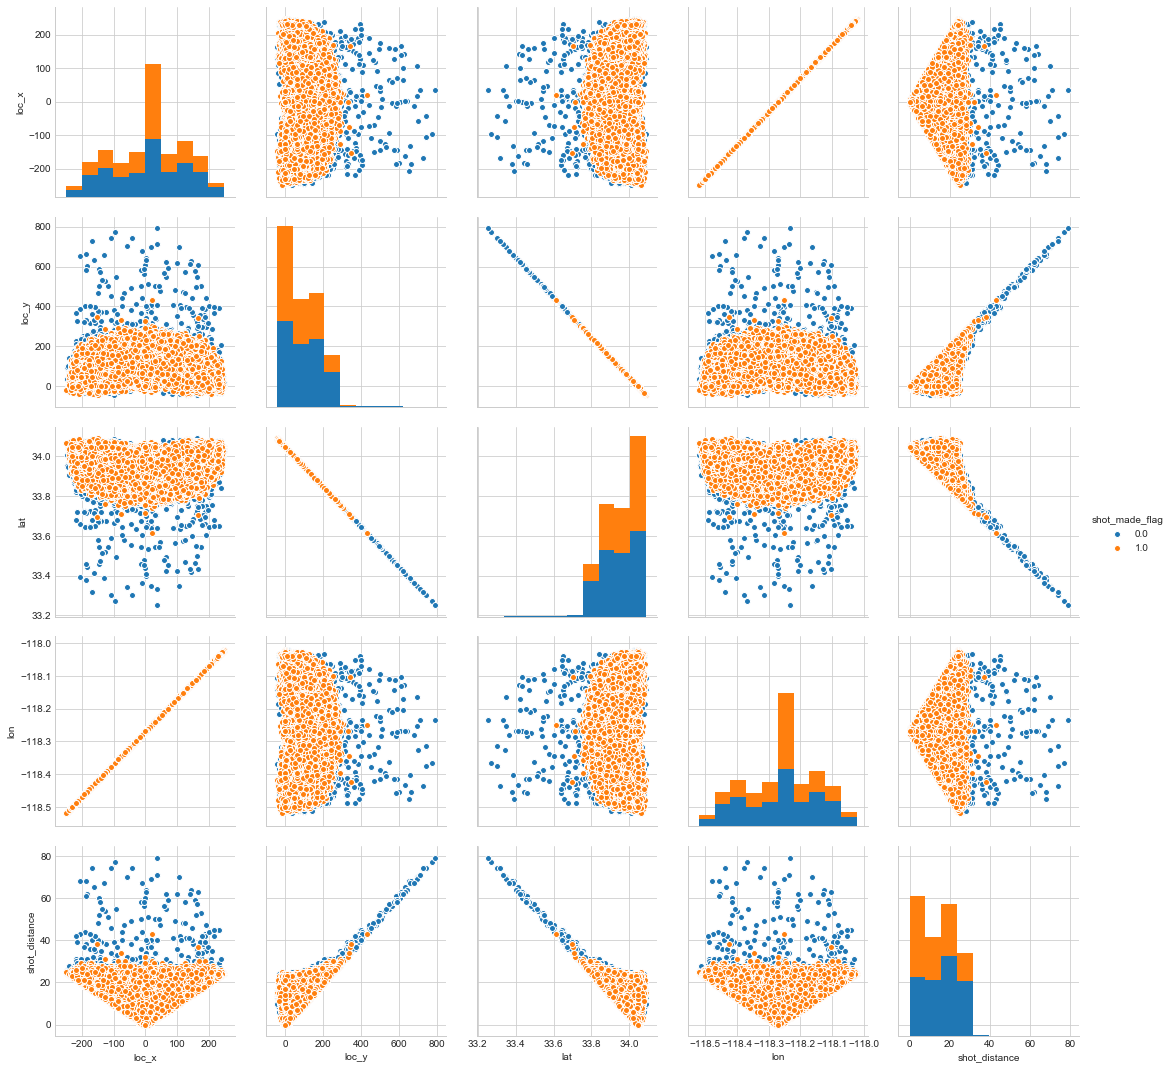

In [15]:
sns.pairplot(data, vars=['loc_x', 'loc_y', 'lat', 'lon', 'shot_distance'], hue='shot_made_flag', size=3)
plt.show()

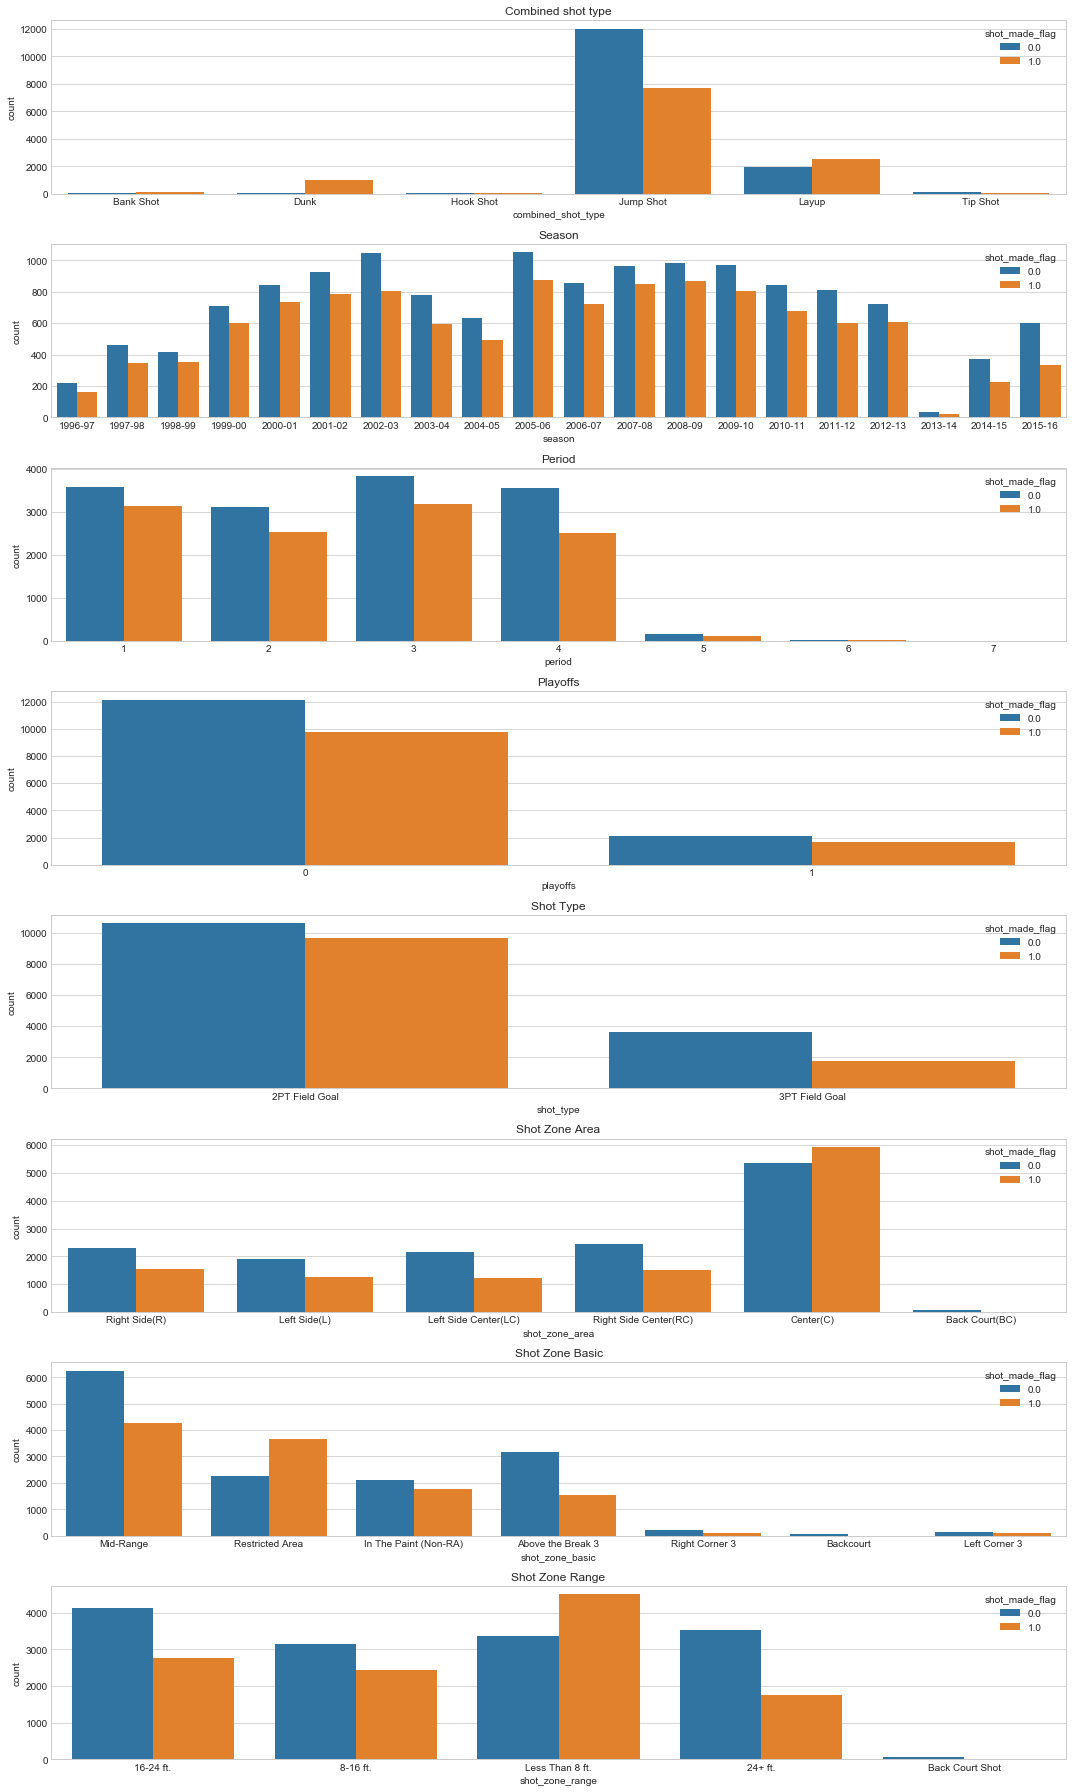

In [16]:
f, axarr = plt.subplots(8, figsize=(15, 25))

sns.countplot(x="combined_shot_type", hue="shot_made_flag", data=data, ax=axarr[0])
sns.countplot(x="season", hue="shot_made_flag", data=data, ax=axarr[1])
sns.countplot(x="period", hue="shot_made_flag", data=data, ax=axarr[2])
sns.countplot(x="playoffs", hue="shot_made_flag", data=data, ax=axarr[3])
sns.countplot(x="shot_type", hue="shot_made_flag", data=data, ax=axarr[4])
sns.countplot(x="shot_zone_area", hue="shot_made_flag", data=data, ax=axarr[5])
sns.countplot(x="shot_zone_basic", hue="shot_made_flag", data=data, ax=axarr[6])
sns.countplot(x="shot_zone_range", hue="shot_made_flag", data=data, ax=axarr[7])

axarr[0].set_title('Combined shot type')
axarr[1].set_title('Season')
axarr[2].set_title('Period')
axarr[3].set_title('Playoffs')
axarr[4].set_title('Shot Type')
axarr[5].set_title('Shot Zone Area')
axarr[6].set_title('Shot Zone Basic')
axarr[7].set_title('Shot Zone Range')

plt.tight_layout()
plt.show()

2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.

In [17]:
unknown_mask = data['shot_made_flag'].isnull()


Data Cleaning
We are assuming an independence of each shot - therefore some columns might be dropped

In [18]:
data_cl = data.copy() # create a copy of data frame
target = data_cl['shot_made_flag'].copy()

# Remove some columns
data_cl.drop('team_id', axis=1, inplace=True) # Always one number
data_cl.drop('lat', axis=1, inplace=True) # Correlated with loc_x
data_cl.drop('lon', axis=1, inplace=True) # Correlated with loc_y
data_cl.drop('game_id', axis=1, inplace=True) # Independent
data_cl.drop('game_event_id', axis=1, inplace=True) # Independent
data_cl.drop('team_name', axis=1, inplace=True) # Always LA Lakers
data_cl.drop('shot_made_flag', axis=1, inplace=True)

There are also many outliers, remove them:

In [19]:
def detect_outliers(series, whis=1.5):
    q75, q25 = np.percentile(series, [75 ,25])
    iqr = q75 - q25
    return ~((series - series.median()).abs() <= (whis * iqr))
## For now - do not remove anything

Data Transformation

In [20]:
#New features#
data_cl['seconds_from_period_end'] = 60 * data_cl['minutes_remaining'] + data_cl['seconds_remaining']
data_cl['last_5_sec_in_period'] = data_cl['seconds_from_period_end'] < 5

data_cl.drop('minutes_remaining', axis=1, inplace=True)
data_cl.drop('seconds_remaining', axis=1, inplace=True)
data_cl.drop('seconds_from_period_end', axis=1, inplace=True)

## Matchup - (away/home)
data_cl['home_play'] = data_cl['matchup'].str.contains('vs').astype('int')
data_cl.drop('matchup', axis=1, inplace=True)

# Game date
data_cl['game_date'] = pd.to_datetime(data_cl['game_date'])
data_cl['game_year'] = data_cl['game_date'].dt.year
data_cl['game_month'] = data_cl['game_date'].dt.month
data_cl.drop('game_date', axis=1, inplace=True)

# Loc_x, and loc_y binning
data_cl['loc_x'] = pd.cut(data_cl['loc_x'], 25)
data_cl['loc_y'] = pd.cut(data_cl['loc_y'], 25)

# Replace 20 least common action types with value 'Other'
rare_action_types = data_cl['action_type'].value_counts().sort_values().index.values[:20]
data_cl.loc[data_cl['action_type'].isin(rare_action_types), 'action_type'] = 'Other'



In [21]:

#Encode categorical variable
categorial_cols = [
    'action_type', 'combined_shot_type', 'period', 'season', 'shot_type',
    'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'game_year',
    'game_month', 'opponent', 'loc_x', 'loc_y']

for cc in categorial_cols:
    dummies = pd.get_dummies(data_cl[cc])
    dummies = dummies.add_prefix("{}#".format(cc))
    data_cl.drop(cc, axis=1, inplace=True)
    data_cl = data_cl.join(dummies)




In [22]:
data_cl.head()

,playoffs,shot_distance,last_5_sec_in_period,home_play,action_type#Alley Oop Dunk Shot,action_type#Alley Oop Layup shot,action_type#Driving Dunk Shot,action_type#Driving Finger Roll Layup Shot,action_type#Driving Finger Roll Shot,action_type#Driving Jump shot,action_type#Driving Layup Shot,action_type#Driving Reverse Layup Shot,action_type#Driving Slam Dunk Shot,action_type#Dunk Shot,action_type#Fadeaway Bank shot,action_type#Fadeaway Jump Shot,action_type#Finger Roll Layup Shot,action_type#Finger Roll Shot,action_type#Floating Jump shot,action_type#Follow Up Dunk Shot,action_type#Hook Shot,action_type#Jump Bank Shot,action_type#Jump Hook Shot,action_type#Jump Shot,action_type#Layup Shot,action_type#Other,action_type#Pullup Jump shot,action_type#Putback Layup Shot,action_type#Reverse Dunk Shot,action_type#Reverse Layup Shot,action_type#Reverse Slam Dunk Shot,action_type#Running Bank shot,action_type#Running Dunk Shot,action_type#Running Hook Shot,action_type#Running Jump Shot,action_type#Running Layup Shot,action_type#Slam Dunk Shot,action_type#Step Back Jump shot,action_type#Tip Shot,action_type#Turnaround Bank shot,action_type#Turnaround Fadeaway shot,action_type#Turnaround Jump Shot,combined_shot_type#Bank Shot,combined_shot_type#Dunk,combined_shot_type#Hook Shot,combined_shot_type#Jump Shot,combined_shot_type#Layup,combined_shot_type#Tip Shot,period#1,period#2,period#3,period#4,period#5,period#6,period#7,season#1996-97,season#1997-98,season#1998-99,season#1999-00,season#2000-01,season#2001-02,season#2002-03,season#2003-04,season#2004-05,season#2005-06,season#2006-07,season#2007-08,season#2008-09,season#2009-10,season#2010-11,season#2011-12,season#2012-13,season#2013-14,season#2014-15,season#2015-16,shot_type#2PT Field Goal,shot_type#3PT Field Goal,shot_zone_area#Back Court(BC),shot_zone_area#Center(C),shot_zone_area#Left Side Center(LC),shot_zone_area#Left Side(L),shot_zone_area#Right Side Center(RC),shot_zone_area#Right Side(R),shot_zone_basic#Above the Break 3,shot_zone_basic#Backcourt,shot_zone_basic#In The Paint (Non-RA),shot_zone_basic#Left Corner 3,shot_zone_basic#Mid-Range,shot_zone_basic#Restricted Area,shot_zone_basic#Right Corner 3,shot_zone_range#16-24 ft.,shot_zone_range#24+ ft.,shot_zone_range#8-16 ft.,shot_zone_range#Back Court Shot,shot_zone_range#Less Than 8 ft.,game_year#1996,game_year#1997,game_year#1998,game_year#1999,game_year#2000,game_year#2001,game_year#2002,game_year#2003,game_year#2004,game_year#2005,game_year#2006,game_year#2007,game_year#2008,game_year#2009,game_year#2010,game_year#2011,game_year#2012,game_year#2013,game_year#2014,game_year#2015,game_year#2016,game_month#1,game_month#2,game_month#3,game_month#4,game_month#5,game_month#6,game_month#10,game_month#11,game_month#12,opponent#ATL,opponent#BKN,opponent#BOS,opponent#CHA,opponent#CHI,opponent#CLE,opponent#DAL,opponent#DEN,opponent#DET,opponent#GSW,opponent#HOU,opponent#IND,opponent#LAC,opponent#MEM,opponent#MIA,opponent#MIL,opponent#MIN,opponent#NJN,opponent#NOH,opponent#NOP,opponent#NYK,opponent#OKC,opponent#ORL,opponent#PHI,opponent#PHX,opponent#POR,opponent#SAC,opponent#SAS,opponent#SEA,opponent#TOR,opponent#UTA,opponent#VAN,opponent#WAS,"loc_x#(-250.498, -230.08]","loc_x#(-230.08, -210.16]","loc_x#(-210.16, -190.24]","loc_x#(-190.24, -170.32]","loc_x#(-170.32, -150.4]","loc_x#(-150.4, -130.48]","loc_x#(-130.48, -110.56]","loc_x#(-110.56, -90.64]","loc_x#(-90.64, -70.72]","loc_x#(-70.72, -50.8]","loc_x#(-50.8, -30.88]","loc_x#(-30.88, -10.96]","loc_x#(-10.96, 8.96]","loc_x#(8.96, 28.88]","loc_x#(28.88, 48.8]","loc_x#(48.8, 68.72]","loc_x#(68.72, 88.64]","loc_x#(88.64, 108.56]","loc_x#(108.56, 128.48]","loc_x#(128.48, 148.4]","loc_x#(148.4, 168.32]","loc_x#(168.32, 188.24]","loc_x#(188.24, 208.16]","loc_x#(208.16, 228.08]","loc_x#(228.08, 248.0]","loc_y#(-44.835, -10.6]","loc_y#(-10.6, 22.8]","loc_y#(22.8, 56.2]","loc_y#(56.2, 89.6]","loc_y#(89.6, 123.0]","loc_y#(123.0, 156.4]","loc_y#(156.4, 189.8]","loc_y#(189.8, 223.2]","loc_y#(223.2


Feature Selection

In [23]:
#Let's reduce the number of features
#Create views for easier analysis

# Separate dataset for validation
data_submit = data_cl[unknown_mask]

# Separate dataset for training
X = data_cl[~unknown_mask]
Y = target[~unknown_mask]

Variance Threshold
Find all features with more than 90% variance in values.

In [24]:
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2

threshold = 0.90
vt = VarianceThreshold().fit(X)

# Find feature names
feat_var_threshold = data_cl.columns[vt.variances_ > threshold * (1-threshold)]
feat_var_threshold

Index(['playoffs', 'shot_distance', 'home_play', 'action_type#Jump Shot',
       'combined_shot_type#Jump Shot', 'combined_shot_type#Layup', 'period#1',
       'period#2', 'period#3', 'period#4', 'shot_type#2PT Field Goal',
       'shot_type#3PT Field Goal', 'shot_zone_area#Center(C)',
       'shot_zone_area#Left Side Center(LC)', 'shot_zone_area#Left Side(L)',
       'shot_zone_area#Right Side Center(RC)', 'shot_zone_area#Right Side(R)',
       'shot_zone_basic#Above the Break 3',
       'shot_zone_basic#In The Paint (Non-RA)', 'shot_zone_basic#Mid-Range',
       'shot_zone_basic#Restricted Area', 'shot_zone_range#16-24 ft.',
       'shot_zone_range#24+ ft.', 'shot_zone_range#8-16 ft.',
       'shot_zone_range#Less Than 8 ft.', 'game_month#1', 'game_month#2',
       'game_month#3', 'game_month#4', 'game_month#11', 'game_month#12',
       'loc_x#(-10.96, 8.96]', 'loc_y#(-10.6, 22.8]', 'loc_y#(22.8, 56.2]',
       'loc_y#(123.0, 156.4]'],
      dtype='object')

In [25]:
vt

VarianceThreshold(threshold=0.0)


Top 20 most important features
According to RandomForestClassifier

In [26]:
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier
model = RandomForestClassifier()
model.fit(X, Y)

feature_imp = pd.DataFrame(model.feature_importances_, index=X.columns, columns=["importance"])
feat_imp_20 = feature_imp.sort_values("importance", ascending=False).head(20).index
feat_imp_20

Index(['shot_distance', 'action_type#Jump Shot', 'home_play', 'period#3',
       'period#2', 'period#1', 'action_type#Layup Shot', 'period#4',
       'game_month#3', 'game_month#1', 'game_month#2', 'game_month#4',
       'combined_shot_type#Jump Shot', 'game_month#12', 'game_month#11',
       'playoffs', 'action_type#Running Jump Shot', 'opponent#SAS',
       'loc_y#(-10.6, 22.8]', 'opponent#PHX'],
      dtype='object')


Univariate feature selection
Select top 20 features using  chi2  test. Features must be positive before applying test.

In [27]:
from sklearn.preprocessing import MinMaxScaler

X_minmax = MinMaxScaler(feature_range=(0,1)).fit_transform(X)
X_scored = SelectKBest(score_func=chi2, k='all').fit(X_minmax, Y)
feature_scoring = pd.DataFrame({
        'feature': X.columns,
        'score': X_scored.scores_
    })

feat_scored_20 = feature_scoring.sort_values('score', ascending=False).head(20)['feature'].values
feat_scored_20

array(['combined_shot_type#Dunk', 'action_type#Jump Shot',
       'shot_zone_basic#Restricted Area', 'loc_x#(-10.96, 8.96]',
       'action_type#Driving Layup Shot',
       'shot_zone_range#Less Than 8 ft.', 'loc_y#(-10.6, 22.8]',
       'action_type#Slam Dunk Shot', 'shot_type#3PT Field Goal',
       'action_type#Driving Dunk Shot', 'shot_zone_area#Center(C)',
       'action_type#Running Jump Shot', 'shot_zone_range#24+ ft.',
       'shot_zone_basic#Above the Break 3', 'combined_shot_type#Layup',
       'combined_shot_type#Jump Shot', 'last_5_sec_in_period',
       'action_type#Jump Bank Shot', 'action_type#Pullup Jump shot',
       'shot_zone_area#Left Side Center(LC)'], dtype=object)

Recursive Feature Elimination¶
Select 20 features from using recursive feature elimination (RFE) with logistic regression model.

In [28]:
from sklearn.linear_model import LogisticRegression

rfe = RFE(LogisticRegression(), 20)
rfe.fit(X, Y)

feature_rfe_scoring = pd.DataFrame({
        'feature': X.columns,
        'score': rfe.ranking_
    })

feat_rfe_20 = feature_rfe_scoring[feature_rfe_scoring['score'] == 1]['feature'].values
feat_rfe_20

array(['action_type#Driving Dunk Shot',
       'action_type#Driving Finger Roll Layup Shot',
       'action_type#Driving Finger Roll Shot',
       'action_type#Driving Slam Dunk Shot', 'action_type#Dunk Shot',
       'action_type#Fadeaway Bank shot', 'action_type#Finger Roll Shot',
       'action_type#Hook Shot', 'action_type#Jump Shot',
       'action_type#Layup Shot', 'action_type#Running Bank shot',
       'action_type#Running Hook Shot', 'action_type#Slam Dunk Shot',
       'combined_shot_type#Dunk', 'combined_shot_type#Tip Shot',
       'shot_zone_area#Back Court(BC)', 'shot_zone_range#Back Court Shot',
       'loc_y#(290.0, 323.4]', 'loc_y#(356.8, 390.2]',
       'loc_y#(390.2, 423.6]'], dtype=object)

Final feature selection
Finally features selected by all methods will be merged together

In [29]:
features = np.hstack([
        feat_var_threshold, 
        feat_imp_20,
        feat_scored_20,
        feat_rfe_20
    ])

features = np.unique(features)
print('Final features set:\n')
for f in features:
    print("\t-{}".format(f))

Final features set:

	-action_type#Driving Dunk Shot
	-action_type#Driving Finger Roll Layup Shot
	-action_type#Driving Finger Roll Shot
	-action_type#Driving Layup Shot
	-action_type#Driving Slam Dunk Shot
	-action_type#Dunk Shot
	-action_type#Fadeaway Bank shot
	-action_type#Finger Roll Shot
	-action_type#Hook Shot
	-action_type#Jump Bank Shot
	-action_type#Jump Shot
	-action_type#Layup Shot
	-action_type#Pullup Jump shot
	-action_type#Running Bank shot
	-action_type#Running Hook Shot
	-action_type#Running Jump Shot
	-action_type#Slam Dunk Shot
	-combined_shot_type#Dunk
	-combined_shot_type#Jump Shot
	-combined_shot_type#Layup
	-combined_shot_type#Tip Shot
	-game_month#1
	-game_month#11
	-game_month#12
	-game_month#2
	-game_month#3
	-game_month#4
	-home_play
	-last_5_sec_in_period
	-loc_x#(-10.96, 8.96]
	-loc_y#(-10.6, 22.8]
	-loc_y#(123.0, 156.4]
	-loc_y#(22.8, 56.2]
	-loc_y#(290.0, 323.4]
	-loc_y#(356.8, 390.2]
	-loc_y#(390.2, 423.6]
	-opponent#PHX
	-opponent#SAS
	-period#1
	-perio


Prepare dataset for further analysis

In [30]:
data_cl = data_cl.ix[:, features]
data_submit = data_submit.ix[:, features]
X = X.ix[:, features]

print('Clean dataset shape: {}'.format(data_cl.shape))
print('Subbmitable dataset shape: {}'.format(data_submit.shape))
print('Train features shape: {}'.format(X.shape))
print('Target label shape: {}'. format(Y.shape))

Clean dataset shape: (30697, 61)
Subbmitable dataset shape: (5000, 61)
Train features shape: (25697, 61)
Target label shape: (25697,)


3. Обучить линейную модель, Lasso, Ridge на тех же признаках - построить сравнительную таблицу коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. Посчитать RSS

In [32]:
#Построим линенйную модель
from sklearn.linear_model import LinearRegression
def linear_regression(X_,Y_):
    linreg = LinearRegression(normalize=True)
    linreg.fit(X_,Y_)
    y_pred = linreg.predict(X_)
    rss = sum((y_pred - Y_.astype(np.int8)) ** 2)  
    Lin=pd.DataFrame(dict(zip(X_.columns,linreg.coef_)),index=[0])
    Lin['rss'] = pd.Series(rss, index=Lin.index)
    #Lin=Lin.T
    Lin=Lin.T.rename(index=str, columns={0: "LR"})
    return Lin

In [132]:
LR_df=linear_regression(X,Y)
LR_df

,LR
action_type#Driving Dunk Shot,4.916497e-02
action_type#Driving Finger Roll Layup Shot,2.049591e-01
action_type#Driving Finger Roll Shot,1.814633e-01
action_type#Driving Layup Shot,6.908298e-02
action_type#Driving Slam Dunk Shot,5.859789e-02
action_type#Dunk Shot,-1.454303e-01
action_type#Fadeaway Bank shot,3.399666e-01
action_type#Finger Roll Shot,-1.976516e-01
action_type#Hook Shot,-3.605622e-01
action_type#Jump Bank Shot,2.120234e-01


In [133]:
 #Построим Ridge-модель
from sklearn.linear_model import Ridge
def ridge_regression(X_,Y_,alpha):
    ridgereg = Ridge(alpha, normalize=True)
    ridgereg.fit(X_,Y_)
    y_pred = ridgereg.predict(X_)
    rss = sum((y_pred - Y_.astype(np.int8)) ** 2)  
    Ridge_=pd.DataFrame(dict(zip(X_.columns,ridgereg.coef_)),index=[0])
    Ridge_['rss'] = pd.Series(rss, index=Ridge_.index)
    Ridge_=Ridge_
    Ridge_=Ridge_.T.rename(index=str, columns={0: "RidR"+'_alpha_'+str(alpha)})
    return Ridge_

In [134]:
alpha_ridge = [1e-4,1e-2, 1, 5, 10]

In [136]:
#Рассчитаем Ридж для нескольких уровней альфа
for i in range(len(alpha_ridge)):
    if i==0:
        Ridge_df=ridge_regression(X,Y,alpha_ridge[i])
        
    else :
        temp=ridge_regression(X,Y,alpha_ridge[i])
        Ridge_df=Ridge_df.merge(temp, left_index=True, right_index=True)
        
    
Ridge_df   

,RidR_alpha_0.0001,RidR_alpha_0.01,RidR_alpha_1,RidR_alpha_5,RidR_alpha_10
action_type#Driving Dunk Shot,0.049308,0.058467,0.130299,0.063498,0.039108
action_type#Driving Finger Roll Layup Shot,0.205045,0.208033,0.149723,0.056589,0.033136
action_type#Driving Finger Roll Shot,0.181496,0.184111,0.137283,0.052140,0.030655
action_type#Driving Layup Shot,0.069114,0.073112,0.082686,0.034999,0.021573
action_type#Driving Slam Dunk Shot,0.058517,0.067719,0.132766,0.063551,0.038990
action_type#Dunk Shot,-0.145380,-0.134267,0.031915,0.030363,0.020979
action_type#Fadeaway Bank shot,0.339595,0.337608,0.208644,0.072421,0.039820
action_type#Finger Roll Shot,-0.197840,-0.192443,-0.050278,-0.011176,-0.004186
action_type#Hook Shot,-0.359527,-0.305776,-0.082156,-0.021685,-0.010446
action_type#Jump Bank Shot,0.211970,0.212010,0.151381,0.054179,0.029901


In [57]:
 #Построим Lasso-модель
from sklearn.linear_model import Lasso
def lasso_regression(X_,Y_,alpha):
    lassoreg = Lasso(alpha=alpha, normalize=True, max_iter=1e5)
    lassoreg.fit(X_,Y_)
    y_pred = lassoreg.predict(X_)
    rss = sum((y_pred - Y_.astype(np.int8)) ** 2)  
    Lasso_=pd.DataFrame(dict(zip(X_.columns,lassoreg.coef_)),index=[0])
    Lasso_['rss'] = pd.Series(rss, index=Lasso_.index)
    Lasso_=Lasso_
    Lasso_=Lasso_.T.rename(index=str, columns={0: "Las0R"+'_alpha_'+str(alpha)})
    return Lasso_

In [110]:
alpha_lasso = [1e-4,1e-2, 1, 5, 10]

In [111]:
#Рассчитаем Lasso для нескольких уровней альфа,  видно что даже
#с маленькими штрафами большинсво коэффициентов стремятся к нулю
Lasso_df=pd.DataFrame({})
for i in range(len(alpha_lasso)):
    if i==0:
        Lasso_df=lasso_regression(X,Y,alpha_lasso[i])
        
        print(111)
    else:
        temp=lasso_regression(X,Y,alpha_lasso[i])
        Lasso_df=Lasso_df.merge(temp, left_index=True, right_index=True)
        print(33)
    #Lasso_df=Lasso_df.merge(temp, left_on='index')
Lasso_df      

111
33
33
33
33


,Las0R_alpha_0.0001,Las0R_alpha_0.01,Las0R_alpha_1,Las0R_alpha_5,Las0R_alpha_10
action_type#Driving Dunk Shot,0.000000,0.000000,0.000000,0.000000,0.000000
action_type#Driving Finger Roll Layup Shot,0.000000,0.000000,0.000000,0.000000,0.000000
action_type#Driving Finger Roll Shot,0.000000,0.000000,0.000000,0.000000,0.000000
action_type#Driving Layup Shot,0.059153,0.000000,0.000000,0.000000,0.000000
action_type#Driving Slam Dunk Shot,0.000000,0.000000,0.000000,0.000000,0.000000
action_type#Dunk Shot,-0.000000,0.000000,0.000000,0.000000,0.000000
action_type#Fadeaway Bank shot,0.000000,0.000000,0.000000,0.000000,0.000000
action_type#Finger Roll Shot,-0.000000,0.000000,0.000000,0.000000,0.000000
action_type#Hook Shot,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
action_type#Jump Bank Shot,0.004353,0.000000,0.000000,0.000000,0.000000


In [131]:
#Замерджим наши релуьтаты по всем моделям в красивую табличку
Merge_df=Lasso_df.merge(Ridge_df, left_index=True, right_index=True)
Merge_df=LR_df.merge(Merge_df, left_index=True, right_index=True)
Merge_df

,LR,Las0R_alpha_0.0001,Las0R_alpha_0.01,Las0R_alpha_1,Las0R_alpha_5,Las0R_alpha_10,RidR_alpha_0.0001,RidR_alpha_0.01,RidR_alpha_1,RidR_alpha_5,RidR_alpha_10
action_type#Driving Dunk Shot,4.916497e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.049308,0.058467,0.130299,0.063498,0.039108
action_type#Driving Finger Roll Layup Shot,2.049591e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.205045,0.208033,0.149723,0.056589,0.033136
action_type#Driving Finger Roll Shot,1.814633e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.181496,0.184111,0.137283,0.052140,0.030655
action_type#Driving Layup Shot,6.908298e-02,0.059153,0.000000,0.000000,0.000000,0.000000,0.069114,0.073112,0.082686,0.034999,0.021573
action_type#Driving Slam Dunk Shot,5.859789e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.058517,0.067719,0.132766,0.063551,0.038990
action_type#Dunk Shot,-1.454303e-01,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.145380,-0.134267,0.031915,0.030363,0.020979
action_type#Fadeaway Bank shot,3.399666e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.339595,0.337608,0.208644,0.072421,0.039820
action_type#Finger Roll Shot,-1.976516e-01,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.197840,-0.192443,-0.050278,-0.011176,-0.004186
action_type#Hook Shot,-3.605622e-01,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.359527,-0.305776,-0.082156,-0.021685,-0.010446
action_type#Jump Bank Shot,2.120234e-01,0.004353,0.000000,0.000000,0.000000,0.000000,0.211970,0.212010,0.151381,0.054179,0.029901


4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC

In [144]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [142]:
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
 #Построим Lasso-модель
from sklearn.linear_model import Lasso
def lasso_regression(X_,Y_,alpha):
    lassoreg = Lasso(alpha=alpha, normalize=True, max_iter=1e5)
    lassoreg.fit(X_,Y_)
    y_pred = lassoreg.predict(X_)
    rss = sum((y_pred - Y_.astype(np.int8)) ** 2)  
    Lasso_=pd.DataFrame(dict(zip(X_.columns,lassoreg.coef_)),index=[0])
    Lasso_['rss'] = pd.Series(rss, index=Lasso_.index)
    Lasso_=Lasso_
    Lasso_=Lasso_.T.rename(index=str, columns={0: "Las0R"+'_alpha_'+str(alpha)})
    return Lasso_

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost
#ROC AUC -0.5 случайное угадывание
xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)
xgb.fit(x_train, y_train)
#y_train_predict = xgb.predict_proba(x_train)[:, 1]
y_test_predict = xgb.predict_proba(x_test)[:, 1]
#roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

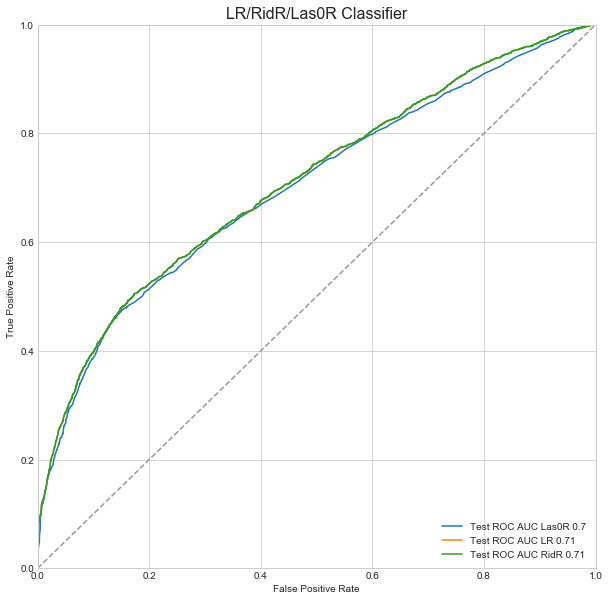

In [176]:
#если сделать мальенькие штрафы результы не слишком отличаются
linreg = LinearRegression(normalize=True)
linreg.fit(X_test,Y_test)
y_test_predict_LR = linreg.predict(X_test)
roc_auc_test_LR = np.round(roc_auc_score(y_test, y_test_predict_LR), 2)

alpha=.0001
ridgereg = Ridge(alpha, normalize=True)
ridgereg.fit(X_test,Y_test)
y_test_predict_RidR = ridgereg.predict(X_test)
roc_auc_test_RidR = np.round(roc_auc_score(y_test, y_test_predict_RidR), 2)


lassoreg = Lasso(alpha, normalize=True)
lassoreg.fit(X_test,Y_test)
y_test_predict_Las0R = lassoreg.predict(X_test)
roc_auc_test_Las0R = np.round(roc_auc_score(y_test, y_test_predict_Las0R), 2)

print("Test_LR: ", roc_auc_test_LR)
print("Test_RidR: ", roc_auc_test_RidR)
print("Test_Las0R: ", roc_auc_test_Las0R)



Test_LR:  0.71
Test_RidR:  0.71
Test_Las0R:  0.7


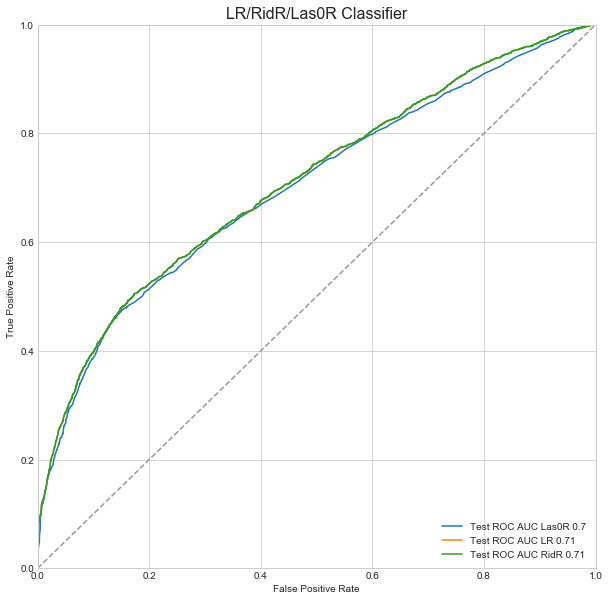

In [177]:
import matplotlib

fpr_test_LR, tpr_test_LR, thresholds_test_LR = roc_curve(y_test, y_test_predict_LR)
fpr_test_RidR, tpr_test_RidR, thresholds_test_RidR = roc_curve(y_test, y_test_predict_RidR)
fpr_test_Las0R, tpr_test_Las0R, thresholds_test_Las0R = roc_curve(y_test, y_test_predict_Las0R)


matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_test_Las0R, tpr_test_Las0R, label='Test ROC AUC {1} {0}'.format(roc_auc_test_Las0R,'Las0R'))
plt.plot(fpr_test_LR, tpr_test_LR, label='Test ROC AUC {1} {0}'.format(roc_auc_test_LR,'LR'))
plt.plot(fpr_test_RidR, tpr_test_RidR, label='Test ROC AUC {1} {0}'.format(roc_auc_test_RidR,'RidR'))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LR/RidR/Las0R Classifier', size=16)
plt.legend(loc='lower right')
plt.show()



In [179]:
"""однако при большом штрафе мы видим что Лассо 
выбирает таргет случайно(мы уже видили это ранее-все коэффициенты занулялись)"""
linreg = LinearRegression(normalize=True)
linreg.fit(X_test,Y_test)
y_test_predict_LR = linreg.predict(X_test)
roc_auc_test_LR = np.round(roc_auc_score(y_test, y_test_predict_LR), 2)

alpha=1
ridgereg = Ridge(alpha, normalize=True)
ridgereg.fit(X_test,Y_test)
y_test_predict_RidR = ridgereg.predict(X_test)
roc_auc_test_RidR = np.round(roc_auc_score(y_test, y_test_predict_RidR), 2)


lassoreg = Lasso(alpha, normalize=True)
lassoreg.fit(X_test,Y_test)
y_test_predict_Las0R = lassoreg.predict(X_test)
roc_auc_test_Las0R = np.round(roc_auc_score(y_test, y_test_predict_Las0R), 2)

print("Test_LR: ", roc_auc_test_LR)
print("Test_RidR: ", roc_auc_test_RidR)
print("Test_Las0R: ", roc_auc_test_Las0R)




Test_LR:  0.71
Test_RidR:  0.69
Test_Las0R:  0.5


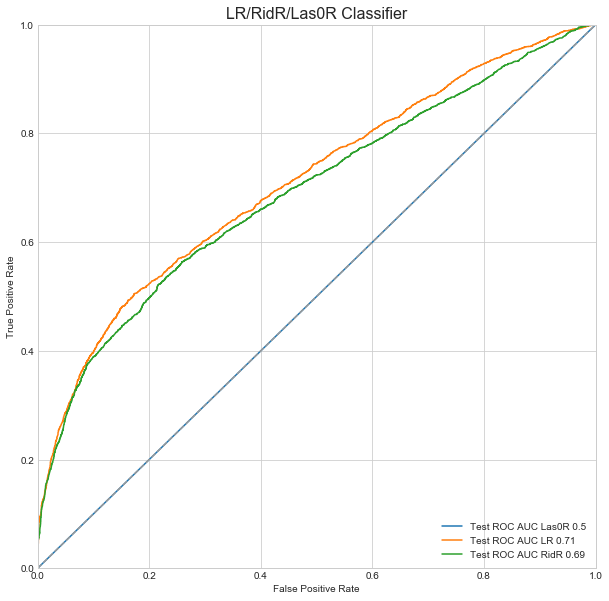

In [180]:
import matplotlib

fpr_test_LR, tpr_test_LR, thresholds_test_LR = roc_curve(y_test, y_test_predict_LR)
fpr_test_RidR, tpr_test_RidR, thresholds_test_RidR = roc_curve(y_test, y_test_predict_RidR)
fpr_test_Las0R, tpr_test_Las0R, thresholds_test_Las0R = roc_curve(y_test, y_test_predict_Las0R)


matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_test_Las0R, tpr_test_Las0R, label='Test ROC AUC {1} {0}'.format(roc_auc_test_Las0R,'Las0R'))
plt.plot(fpr_test_LR, tpr_test_LR, label='Test ROC AUC {1} {0}'.format(roc_auc_test_LR,'LR'))
plt.plot(fpr_test_RidR, tpr_test_RidR, label='Test ROC AUC {1} {0}'.format(roc_auc_test_RidR,'RidR'))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LR/RidR/Las0R Classifier', size=16)
plt.legend(loc='lower right')
plt.show()



5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [185]:
from sklearn.decomposition import PCA, KernelPCA

components = 8
pca = PCA(n_components=components).fit(X)

Text(0,0.5,'explained_variance_ratio_')

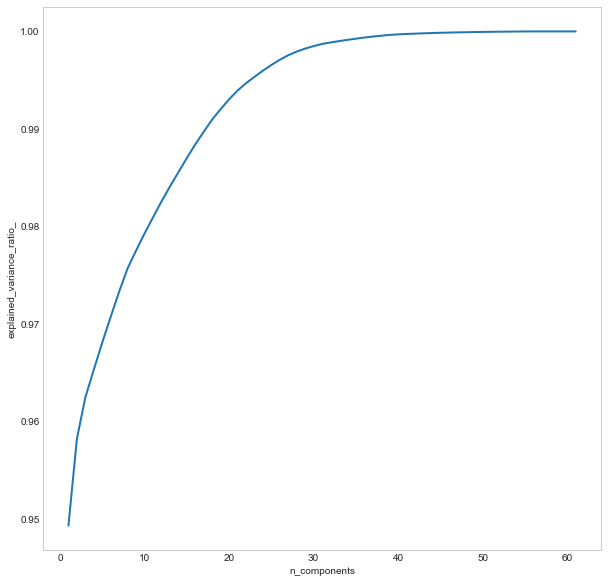

In [189]:
components = 8
pca = PCA().fit(X)

cum_evr = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(cum_evr.size) + 1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')


In [191]:
# Как видим у нас 1ый компонент объясняют 95% вариативности,2ой- 0,9. В целом 99% дисперсии можно обяснить 20 компонентами
np.set_printoptions(suppress=True)
pca.explained_variance_ratio_ * 100

array([94.92856843,  0.89019341,  0.42586201,  0.28417822,  0.27799217,
        0.26534476,  0.25746824,  0.23926126,  0.18244146,  0.17458503,
        0.16511965,  0.16317727,  0.15329615,  0.14653444,  0.14565584,
        0.1407951 ,  0.12904617,  0.12642829,  0.10553446,  0.10134496,
        0.08983017,  0.07553579,  0.06536565,  0.06342266,  0.05823459,
        0.05395613,  0.04668986,  0.03722303,  0.03072416,  0.02539661,
        0.02210496,  0.01514947,  0.01388269,  0.0128572 ,  0.01206448,
        0.0119354 ,  0.00961219,  0.00904303,  0.0082823 ,  0.0055766 ,
        0.00429485,  0.00331652,  0.0032159 ,  0.00272027,  0.00264941,
        0.00207275,  0.00195207,  0.00180323,  0.00153853,  0.0014887 ,
        0.00116866,  0.00110022,  0.00100469,  0.00078532,  0.00071226,
        0.00046231,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])